# Getting Started

Follow the general instructions from hw1_Q1

In [1]:
# get to the parent dir of mai_dul repo
import os

# os.chdir('../../')
os.getcwd()

'/home/ordem/PycharmProjects/MAI_DUL_WS24/homeworks/hw1'

In [2]:
# run only once at the beginning of working on hw1
# !unzip -qq homeworks/hw1/data/hw1_data.zip -d homeworks/hw1/data/

# install latest version deepul package
# !pip install -e .

# Question 2 PixelCNNs part (b) - optional

In [3]:
import numpy as np
from deepul.hw1_helper import (
    # Q2
    q2a_save_results,
    q2b_save_results,
    visualize_q2a_data,
    visualize_q2b_data,
)

## PixelCNN on Colored Shapes and MNIST: Independent Color Channels

For the next part, we'll work with color images (shapes and MNIST). Run the cell below to visualize the dataset.

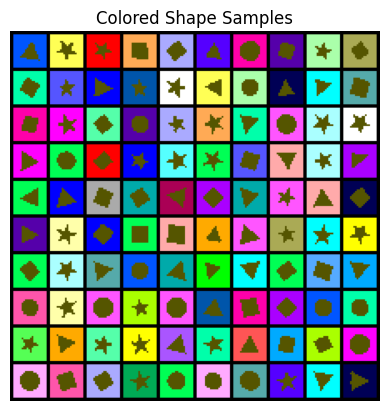

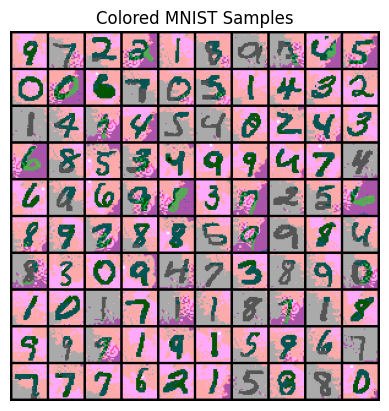

In [4]:
visualize_q2b_data(1)
visualize_q2b_data(2)

Now, implement a PixelCNN to support RGB color channels (or augment your existing implementation). **For simplification, assume color channels to be independent.** More formally, we model the following parameterized distribution:

$$p_\theta(x) = \prod_{i=1}^{HW}\prod_{c=1}^C p_\theta(x_i^c | x_{<i})$$

Here are some tips that you may find useful for designing and training these models:
* You will need a 4-way softmax for every prediction, as opposed to a 256-way softmax in the PixelCNN paper, since the dataset is quantized to two bits per color channel
* You can set the number of filters for each convolutions to 120. You can use the ReLU nonlinearity throughout.
* Use a stack of 8 residual block architecture from [Figure 5](https://arxiv.org/abs/1601.06759) but with 7 x 7 masked convolutions in the middle instead of 3 x 3 masked convolutions
* Consider using [layer normalization](https://arxiv.org/abs/1607.06450) to improve performance. However, be careful to maintain the autoregressive property.
* With a learning rate of $10^{-3}$ and a batch size of 128, it should take a few minutes to run on the shapes dataset, and about 50-60 minutes on MNIST.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [5]:
from torch.optim import Adam
from models.ColoredPixelCNN import ColoredPixelCNN
from utils import rescale_tensor
import torch
from torch.utils.data import TensorDataset, DataLoader


def q2_b(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    image_shape: (H, W, C), height, width, and # of channels of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets
    
    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
    """
    batch_size = 128
    learning_rate = 0.001
    max_epochs = 10

    # rescale from 0/1 to -1/+1
    train_dataset = TensorDataset(torch.tensor(train_data).permute((0, 3, 1, 2)).float())
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    x_test = torch.tensor(test_data).permute((0, 3, 1, 2)).float()

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    x_test = x_test.to(device)

    model = ColoredPixelCNN(filters=64)
    model.to(device)

    optimizer = Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    test_losses = []
    for epoch in range(max_epochs):
        batches = iter(train_loader)

        batch_train_loss = np.empty(len(batches))
        for i, [batch_x] in enumerate(batches):
            batch_x = batch_x.to(device)
            logits = model.forward(batch_x)

            loss = model.loss_function(batch_x, logits)
            batch_train_loss[i] = loss

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        train_losses.append(batch_train_loss.mean().item())

        model.eval()
        with torch.no_grad():
            test_logits = model.forward(x_test)
            test_loss = model.loss_function(x_test, test_logits)
            test_losses.append(test_loss.item())
        model.train()
        print(f"epoch {epoch + 1}/{max_epochs}, train loss: {train_losses[-1]}, test loss: {test_losses[-1]}")
    samples = model.generate(100, device).permute((0, 2, 3, 1)).numpy(force=True)
    return train_losses, test_losses, samples

### Results

Once you've implemented `q2_b`, execute the cells below to visualize and save your results



In [8]:
q2b_save_results(1, 'b', q2_b)

KeyboardInterrupt: 

In [ ]:
q2b_save_results(2, 'b', q2_b)